# Masking MRS slices in each spectral band

One of the primary calibration data products (CDP) of the CALSPEC2 pipeline is the MRS DISTORTION CDP. This product contains information on the MRS integral-field-unit projected slices on the detector, along with the spatial and spectral distortion introduced by the optics. In this notebook we show how (/how well) the slice maps extension of the DISTORTION CDP represents the data. You can also think of this as a sanity check, where the slices should denote the 80% transmission cut-off of a flat source observed with the MRS. The 80% transmission value was used by Adrian Glauser to define the slice mask (see MIRI-TN-00001-ETH issue 2.1).

In [1]:
import funcs
import mrsobs

import numpy as np
from astropy.convolution import convolve,Box2DKernel
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
# Define paths to data
workDir   = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir    = workDir+'cdp_data/'
d2cMapDir = workDir+'distortionMaps/'
lvl2path  = workDir+'FM_data/LVL2/'

In [3]:
# load objects
sliceMap_0percent = funcs.load_obj('sliceMap_0percent')

In [4]:
# Define the ids of the individual slices
sliceid1=[111,121,110,120,109,119,108,118,107,117,106,116,105,115,104,114,103,113,102,112,101]
sliceid2=[201,210,202,211,203,212,204,213,205,214,206,215,207,216,208,217,209]
sliceid3=[316,308,315,307,314,306,313,305,312,304,311,303,310,302,309,301]
sliceid4=[412,406,411,405,410,404,409,403,408,402,407,401]

# # Initialize placeholder
# sliceMap_0percent = {}

In [5]:
sliceMap,alphaMap,sci_signal = {},{},{}
for band in ['1A','1B','1C','2A','2B','2C','3A','3B','3C','4A','4B','4C']:
    # Load slice mask extension of distortion map
    d2cMaps = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
    sliceMap[band] = d2cMaps['sliceMap']
    alphaMap[band] = d2cMaps['alphaMap']
    
    # Load fringe correction map and replace NaNs by 1
    fringe_img = funcs.get_cdps(band,cdpDir,output='img')[0]
    fringe_img[np.isnan(fringe_img)] = 1
    
    # Load external extended source signal
    if band == '4C':
        source_signal,bkg_signal = mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp='400K',output='img')
        sci_signal[band] = (source_signal-bkg_signal)/fringe_img
    else:
        source_signal,bkg_signal = mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp='800K',output='img')
        sci_signal[band] = (source_signal-bkg_signal)/fringe_img 

<IPython.core.display.Javascript object>


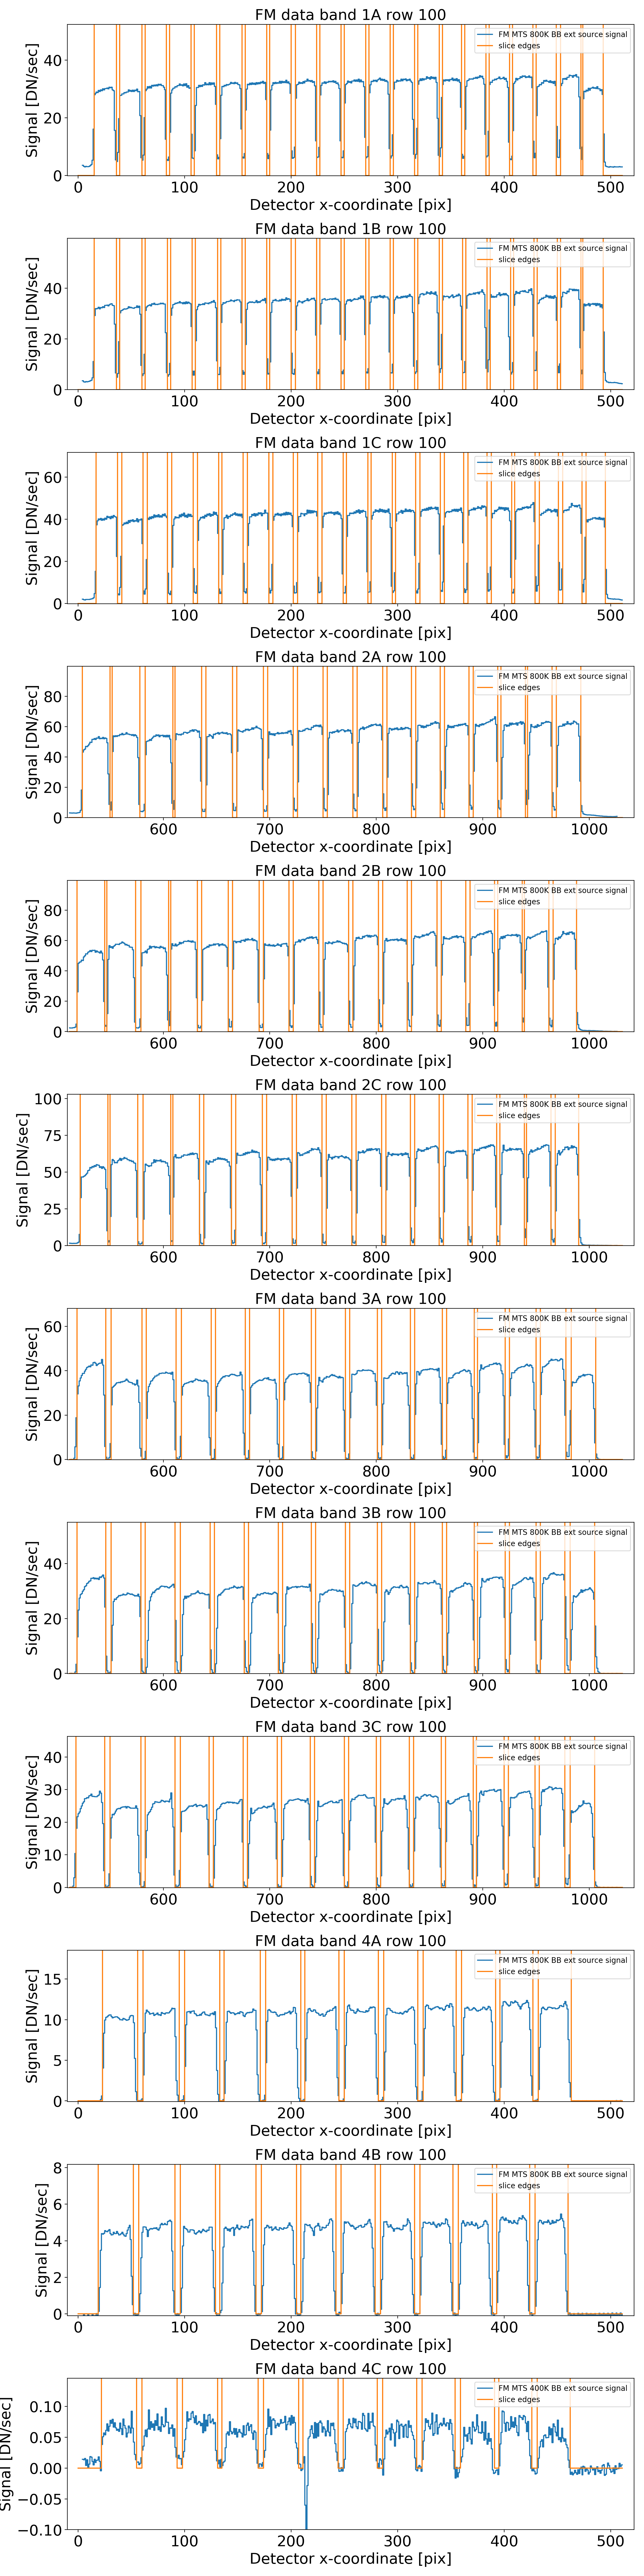

In [8]:
plt.close('all')
row = 100
fig,axs = plt.subplots(12,1,figsize=(12,48))
for plot,band in enumerate(['1A','1B','1C','2A','2B','2C','3A','3B','3C','4A','4B','4C']):
    axs[plot].set_title('FM data band {} row {}'.format(band,row),fontsize=20)
    if band[0] in ['1','4']:
        if band == '4C': label = 'FM MTS 400K BB ext source signal'
        else: label = 'FM MTS 800K BB ext source signal'
        axs[plot].step(np.arange(len(sci_signal[band][row,:512])),sci_signal[band][row,:512],label=label)
        axs[plot].step(np.arange(len(sliceMap[band][row,:512])),sliceMap[band][row,:512]*1000.,label='slice edges')
        axs[plot].set_ylim(-0.1,1.5*np.max(sci_signal[band][row,:512][~np.isnan(sci_signal[band][row,:512])]))
        axs[plot].set_xlim(-10,522)
    elif band[0] in ['2','3']:
        axs[plot].step(512+np.arange(len(sci_signal[band][row,512:])),sci_signal[band][row,512:],label='FM MTS 800K BB ext source signal')
        axs[plot].step(512+np.arange(len(sliceMap[band][row,512:])),sliceMap[band][row,512:]*1000.,label='slice edges')
        axs[plot].set_ylim(-0.1,1.5*np.max(sci_signal[band][row,512:][~np.isnan(sci_signal[band][row,512:])]))
        axs[plot].set_xlim(510,1042)
    axs[plot].set_xlabel('Detector x-coordinate [pix]',fontsize=20)
    axs[plot].set_ylabel('Signal [DN/sec]',fontsize=20)
    axs[plot].legend(loc='upper right',fontsize=10)
    axs[plot].tick_params(axis='both',labelsize=20)
plt.tight_layout()

<IPython.core.display.Javascript object>


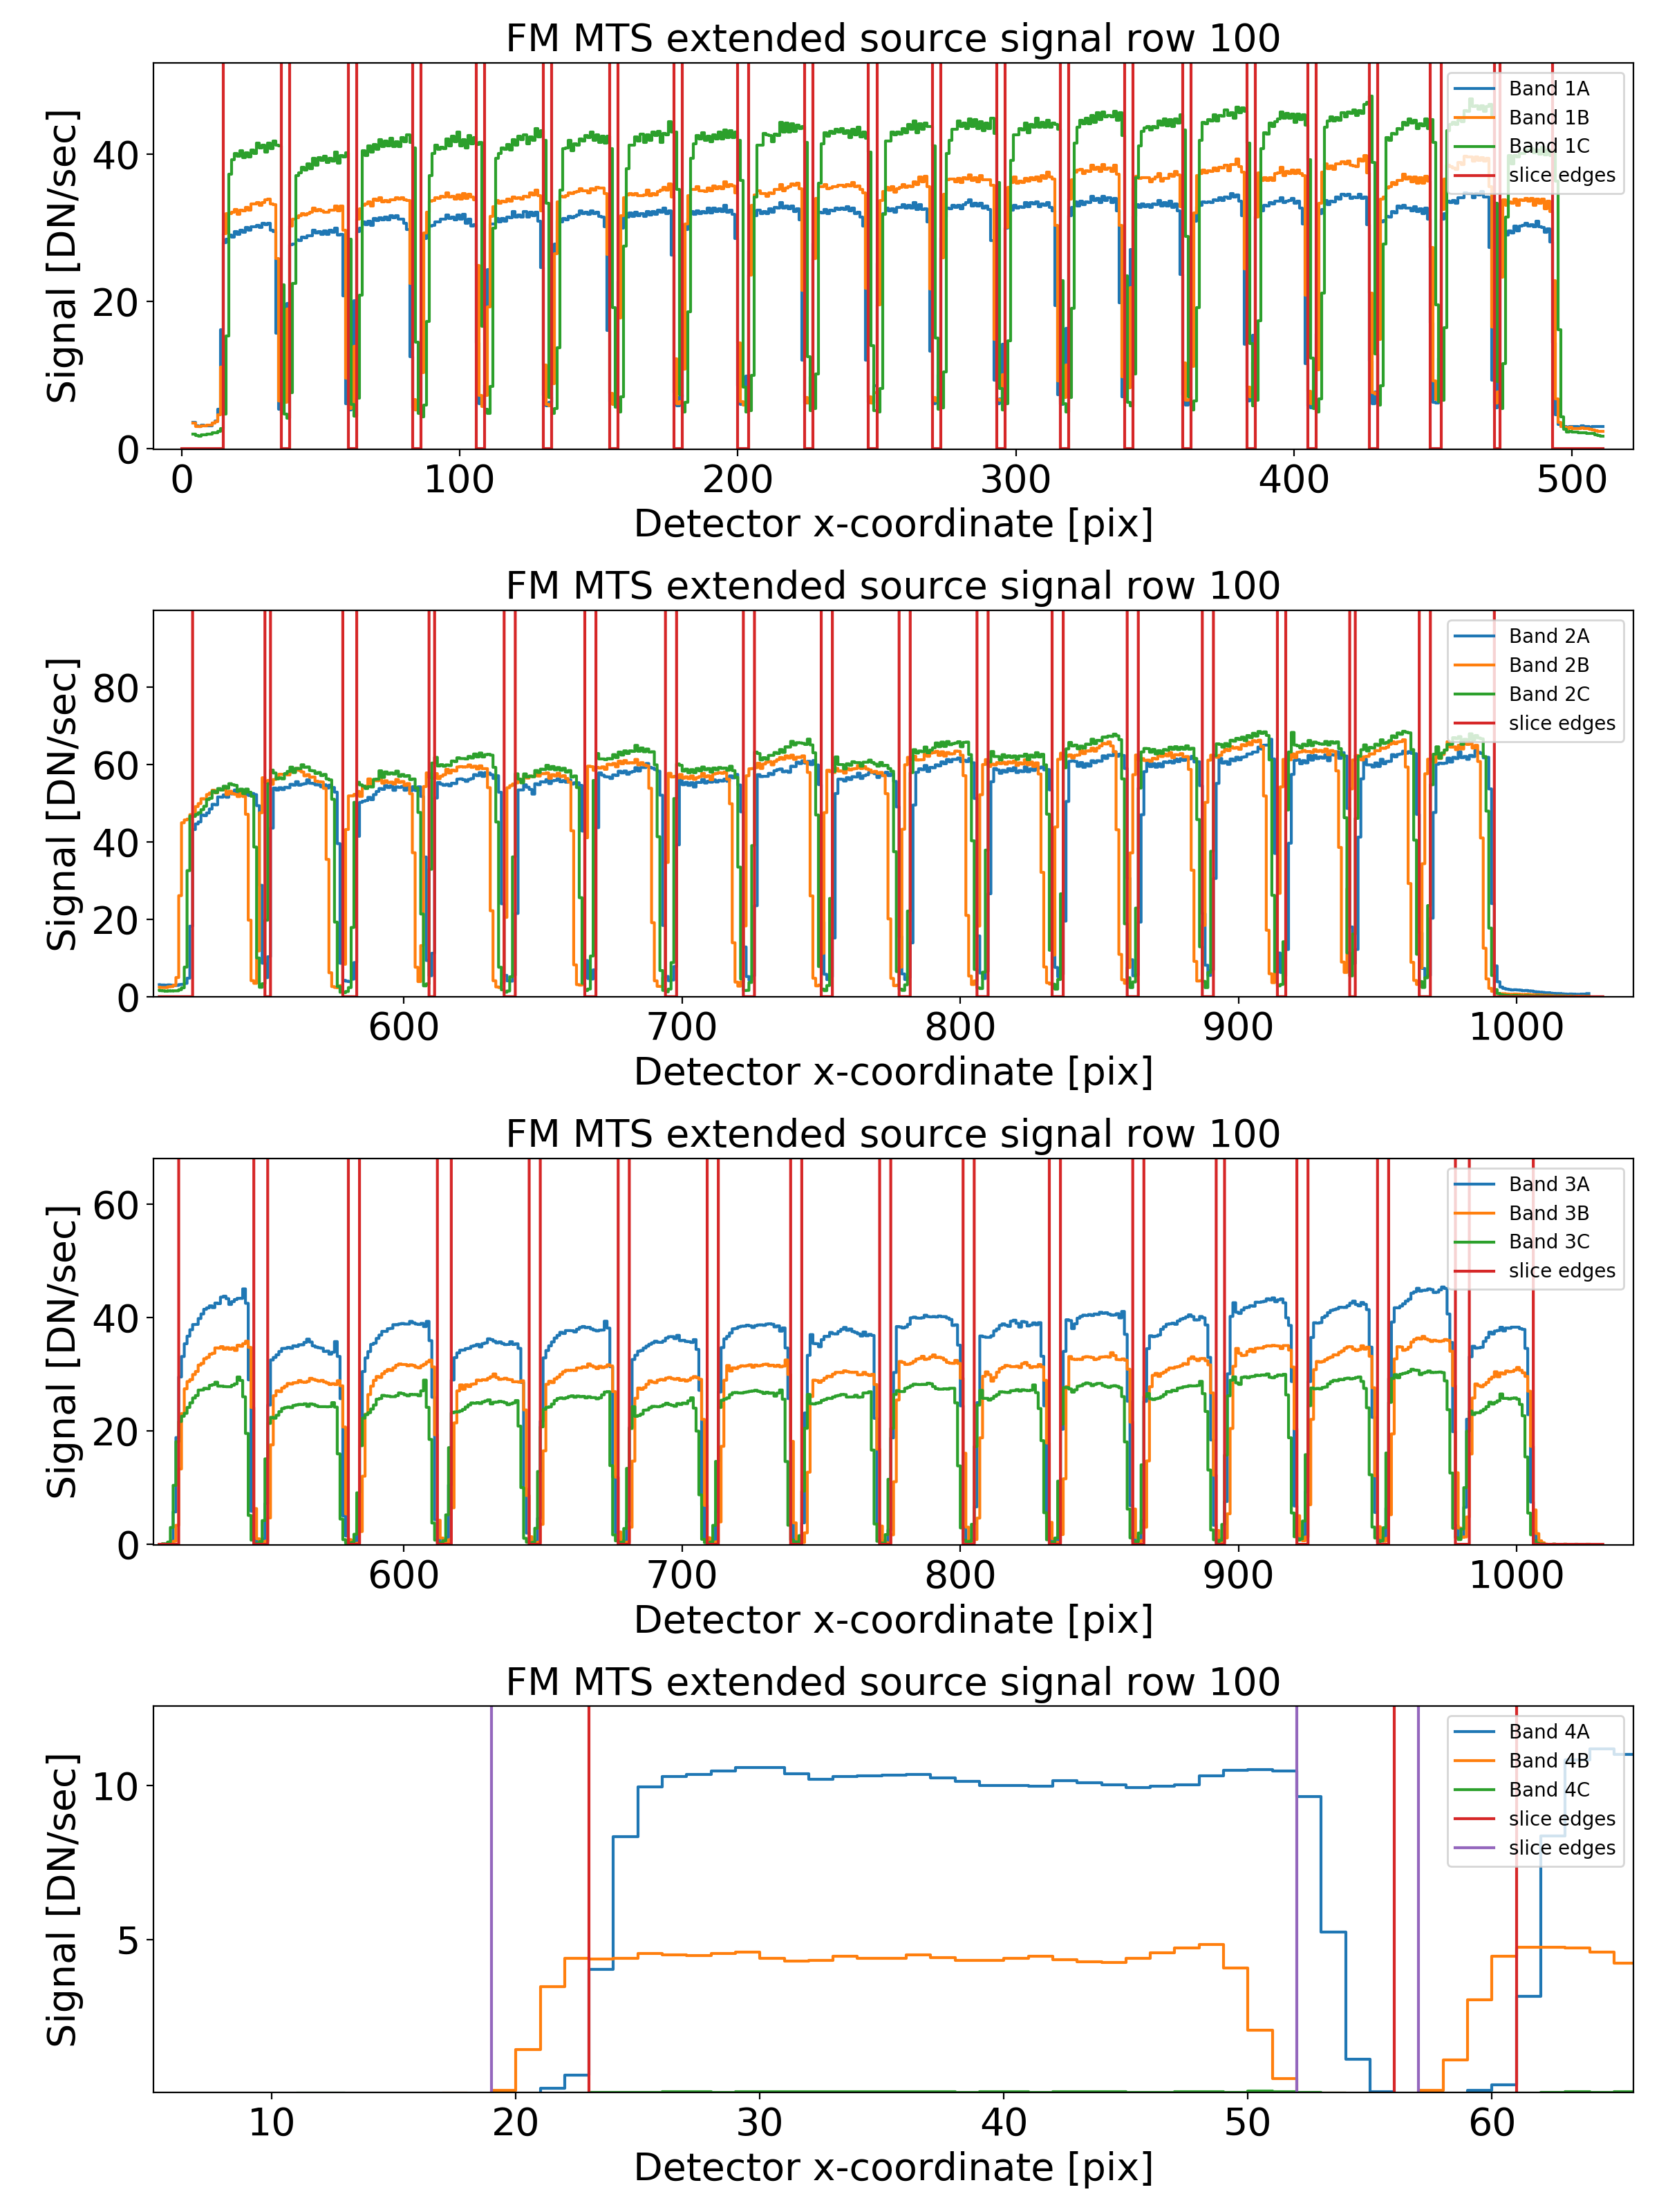

In [12]:
plt.close('all')
row = 100
fig,axs = plt.subplots(4,1,figsize=(12,16))
for band in ['1A','1B','1C']:
    axs[0].step(np.arange(len(sci_signal[band][row,:512])),sci_signal[band][row,:512],label='Band {}'.format(band))
axs[0].step(np.arange(len(sliceMap['1A'][row,:512])),sliceMap['1A'][row,:512]*1000.,label='slice edges')
axs[0].set_ylim(-0.1,1.5*np.max(sci_signal['1A'][row,:512][~np.isnan(sci_signal['1A'][row,:512])]))
axs[0].set_xlim(-10,522)
for band in ['2A','2B','2C']:
    axs[1].step(512+np.arange(len(sci_signal[band][row,512:])),sci_signal[band][row,512:],label='Band {}'.format(band))
axs[1].step(512+np.arange(len(sliceMap['2A'][row,512:])),sliceMap['2A'][row,512:]*1000.,label='slice edges')
axs[1].set_ylim(-0.1,1.5*np.max(sci_signal['2A'][row,512:][~np.isnan(sci_signal['2A'][row,512:])]))
axs[1].set_xlim(510,1042)
for band in ['3A','3B','3C']:
    axs[2].step(512+np.arange(len(sci_signal[band][row,512:])),sci_signal[band][row,512:],label='Band {}'.format(band))
axs[2].step(512+np.arange(len(sliceMap['3A'][row,512:])),sliceMap['3A'][row,512:]*1000.,label='slice edges')
axs[2].set_ylim(-0.1,1.5*np.max(sci_signal['3A'][row,512:][~np.isnan(sci_signal['3A'][row,512:])]))
axs[2].set_xlim(510,1042)
for band in ['4A','4B','4C']:
    axs[3].step(np.arange(len(sci_signal[band][row,:512])),sci_signal[band][row,:512],label='Band {}'.format(band))
axs[3].step(np.arange(len(sliceMap['4A'][row,:512])),sliceMap['4A'][row,:512]*1000.,label='slice edges')
axs[3].step(np.arange(len(sliceMap['4B'][row,:512])),sliceMap['4B'][row,:512]*1000.,label='slice edges')
axs[3].set_ylim(-0.1,1.5*np.max(sci_signal['4A'][row,:512][~np.isnan(sci_signal['4A'][row,:512])]))
axs[3].set_xlim(-10,522)
for plot in range(4):
    axs[plot].set_title('FM MTS extended source signal row {}'.format(row),fontsize=20)
    axs[plot].set_xlabel('Detector x-coordinate [pix]',fontsize=20)
    axs[plot].set_ylabel('Signal [DN/sec]',fontsize=20)
    axs[plot].legend(loc='upper right',fontsize=10)
    axs[plot].tick_params(axis='both',labelsize=20)
plt.tight_layout()

In [78]:
# Derive slice map - channel 1
band = '1C' # '1A','1B','1C'

sliceMap_0percent[band] = np.zeros((1024,1032))
for row in range(1,1023):
    if row%100 == 0:
        print 'Row {}'.format(row)
    peaks = funcs.find_peaks(-convolve(sci_signal[band],Box2DKernel(2))[row,:512], thres=0., min_dist=20)
    if (peaks[-1]<500):
        peaks = np.insert(peaks,len(peaks),511)
    if (len(peaks) != len(sliceid1)+1) :
        peaks = funcs.find_peaks(-convolve(sci_signal[band],Box2DKernel(2))[row,:512]-np.min(-convolve(sci_signal[band],Box2DKernel(2))[row,:512][~np.isnan(-convolve(sci_signal[band],Box2DKernel(2))[row,:512])]), thres=0., min_dist=20)
    for i in range(len(peaks)-1):
        sliceMap_0percent[band][row,peaks[i]:peaks[i+1]] = sliceid1[i]
sliceMap_0percent[band][0,:]  = sliceMap_0percent[band][1,:].copy()
sliceMap_0percent[band][-1,:] = sliceMap_0percent[band][-2,:].copy()

Row 100
Row 200
Row 300
Row 400
Row 500
Row 600
Row 700
Row 800
Row 900
Row 1000


<IPython.core.display.Javascript object>


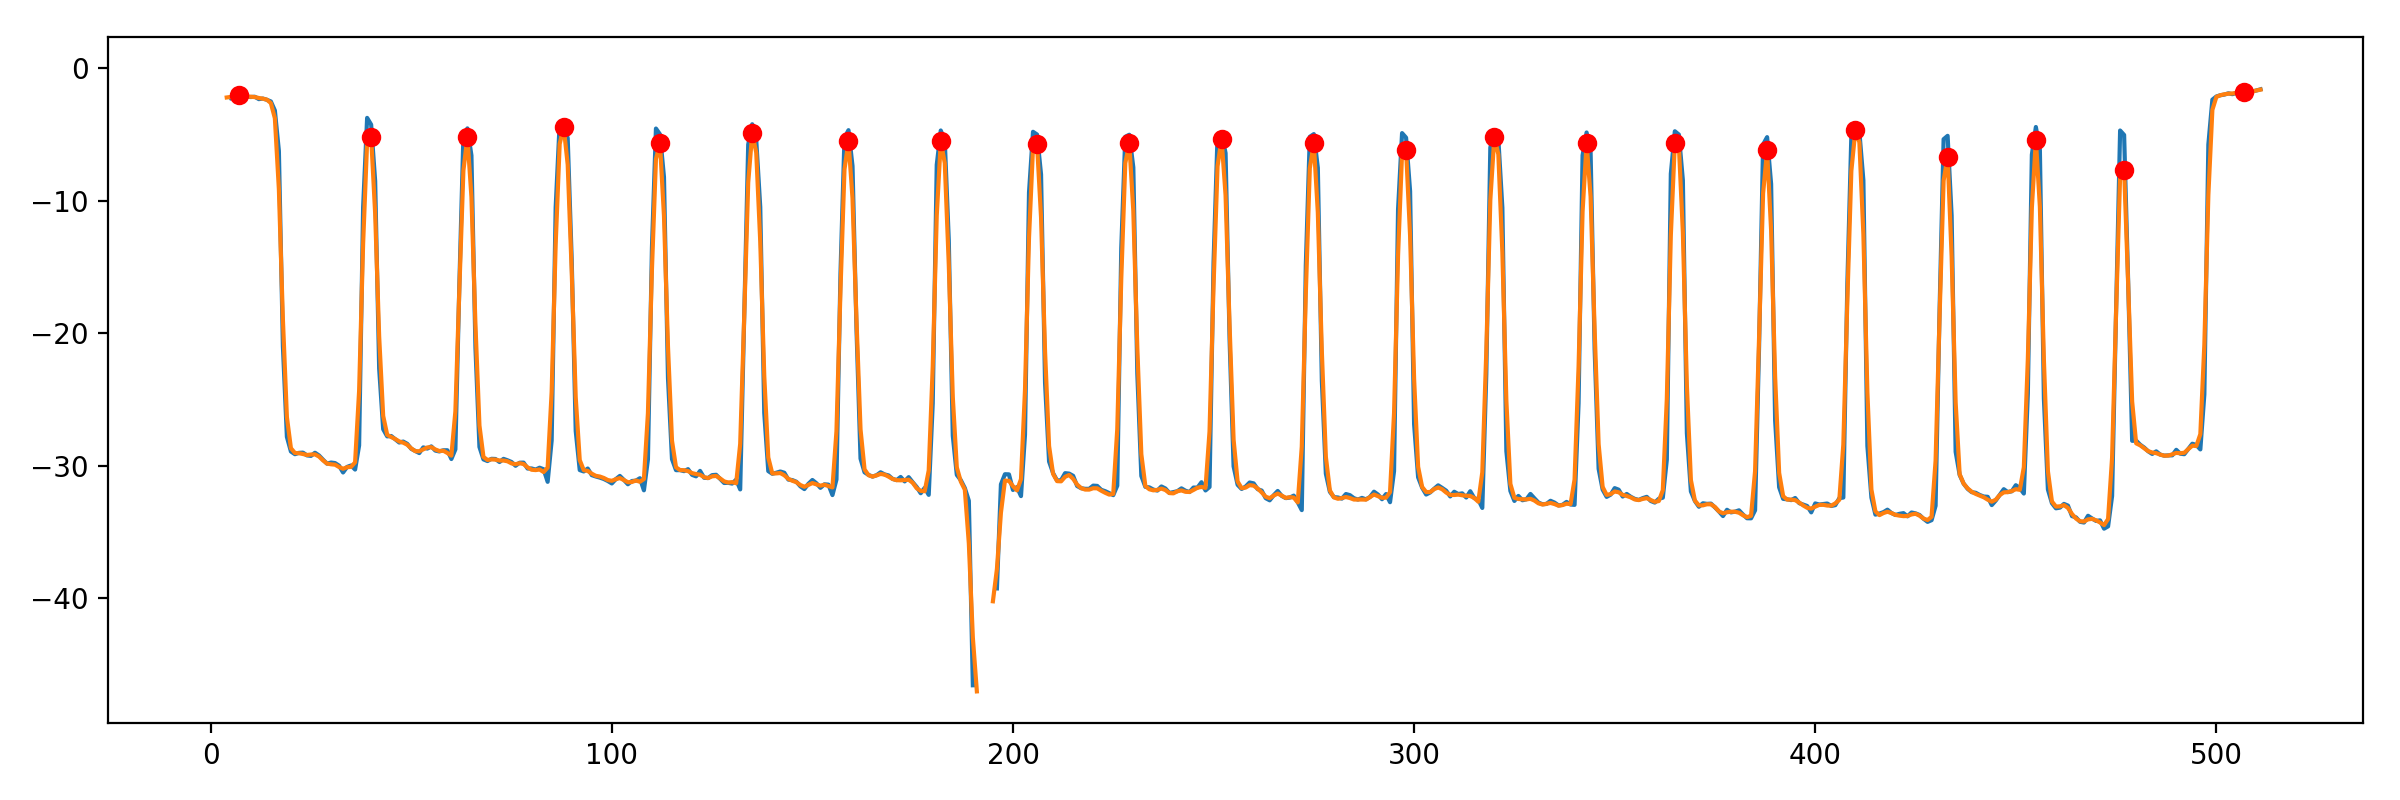

In [84]:
# Test single row - channel 1
band = '1B'
row  = 596

test_img = np.zeros(len(sci_signal[band][row,:512]))
peaks = funcs.find_peaks(-convolve(sci_signal[band],Box2DKernel(2))[row,:512], thres=0., min_dist=20)
if (len(peaks) == len(sliceid1)) & (peaks[-1]<500):
    peaks = np.insert(peaks,len(peaks),511)
if len(peaks) != len(sliceid1)+1:
    peaks = funcs.find_peaks(-convolve(sci_signal[band],Box2DKernel(2))[row,:512]-np.min(-convolve(sci_signal[band],Box2DKernel(2))[row,:512][~np.isnan(-convolve(sci_signal[band],Box2DKernel(2))[row,:512])]), thres=0., min_dist=20)

plt.figure(figsize=(12,4))
plt.plot(-sci_signal[band][row,:512])
plt.plot(-convolve(sci_signal[band],Box2DKernel(2))[row,:512])
plt.plot(peaks,-convolve(sci_signal[band],Box2DKernel(2))[row,:512][peaks],'ro')
plt.tight_layout()

In [156]:
# Derive slice map - channel 2
band = '2C' # '2A','2B','2C'

sliceMap_0percent[band] = np.zeros((1024,1032))
for row in range(1,1023):
    if row%100 == 0:
        print 'Row {}'.format(row)
    peaks = funcs.find_peaks(-convolve(sci_signal[band],Box2DKernel(2))[row,512:1011], thres=0., min_dist=20)
    if (512+peaks[-1]<985):
        peaks = np.insert(peaks,len(peaks),1010-512)
    if (512+peaks[0]>530):
        peaks = np.insert(peaks,0,512-512)
    if (len(peaks) != len(sliceid2)+1) :
        peaks = funcs.find_peaks(-convolve(sci_signal[band],Box2DKernel(2))[row,512:1011]-np.min(-convolve(sci_signal[band],Box2DKernel(2))[row,512:1011][~np.isnan(-convolve(sci_signal[band],Box2DKernel(2))[row,512:1011])]), thres=0., min_dist=20)
    for i in range(len(peaks)-1):
        sliceMap_0percent[band][row,512+peaks[i]:512+peaks[i+1]] = sliceid2[i]
sliceMap_0percent[band][0,:]  = sliceMap_0percent[band][1,:].copy()
sliceMap_0percent[band][-1,:] = sliceMap_0percent[band][-2,:].copy()

Row 100
Row 200
Row 300
Row 400
Row 500
Row 600
Row 700
Row 800
Row 900
Row 1000


[ 522  555  584  614  643  672  701  729  758  786  814  841  868  895  922
  948  974 1010]


<IPython.core.display.Javascript object>


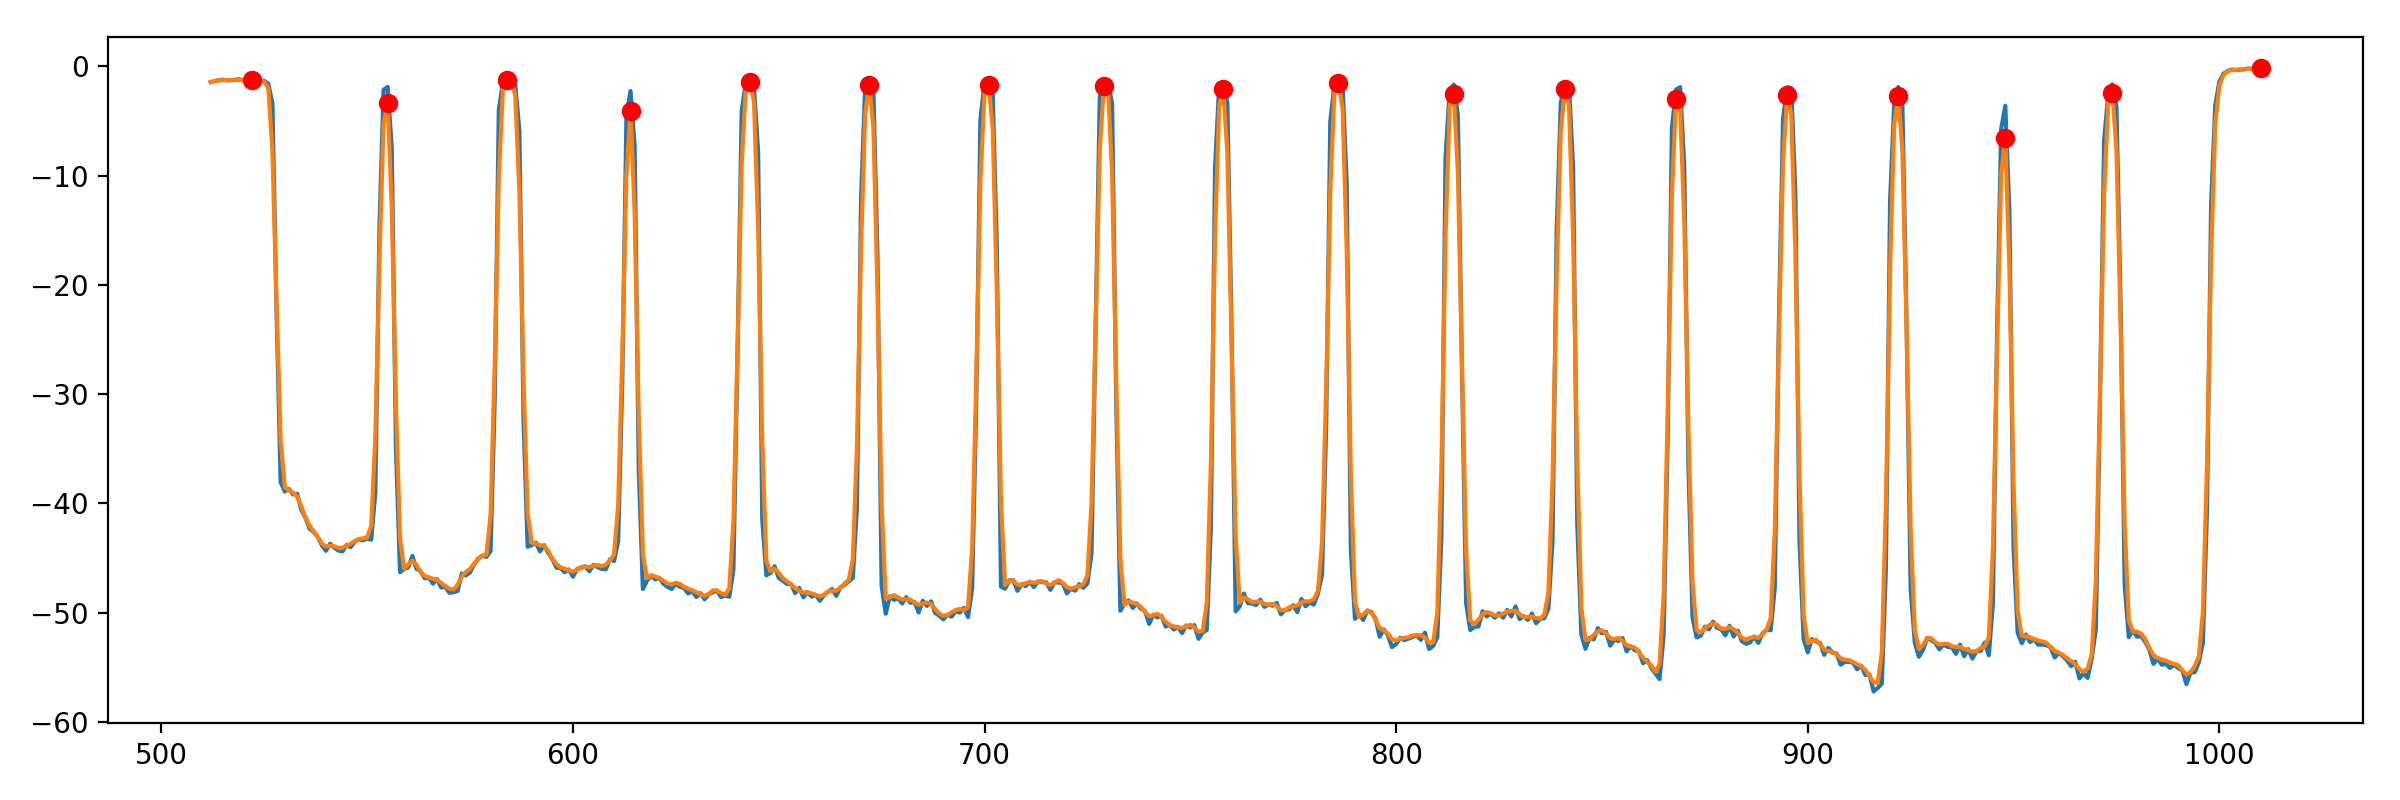

In [152]:
# Test single row - channel 2
band = '2B'
row  = 625

test_img = np.zeros(len(sci_signal[band][row,512:1011]))
peaks = funcs.find_peaks(-convolve(sci_signal[band],Box2DKernel(2))[row,512:1011], thres=0., min_dist=20)
if (512+peaks[-1]<985):
    peaks = np.insert(peaks,len(peaks),1010-512)
if (512+peaks[0]>530):
    peaks = np.insert(peaks,0,0)
# if (len(peaks) != len(sliceid2)+1) :
#     peaks = funcs.find_peaks(-convolve(sci_signal[band],Box2DKernel(2))[row,512:1011]-np.min(-convolve(sci_signal[band],Box2DKernel(2))[row,512:1011][~np.isnan(-convolve(sci_signal[band],Box2DKernel(2))[row,512:1011])]), thres=0., min_dist=20)

plt.figure(figsize=(12,4))
plt.plot(512+np.arange(len(sci_signal[band][row,512:1011])),-sci_signal[band][row,512:1011])
plt.plot(512+np.arange(len(sci_signal[band][row,512:1011])),-convolve(sci_signal[band],Box2DKernel(2))[row,512:1011])
plt.plot(512+peaks,-convolve(sci_signal[band],Box2DKernel(2))[row,512:1011][peaks],'ro')
plt.tight_layout()

In [222]:
# Derive slice map - channel 3
band = '3C' # '3A','3B','3C'

sliceMap_0percent[band] = np.zeros((1024,1032))
for row in range(1,1023):
    if row%100 == 0:
        print 'Row {}'.format(row)
    peaks = funcs.find_peaks(-convolve(sci_signal[band],Box2DKernel(2))[row,512:], thres=0., min_dist=25)
    if (512+peaks[0]>530):
        peaks = np.insert(peaks,0,512-512)
    if (len(peaks) != len(sliceid3)+1) :
        peaks = funcs.find_peaks(-convolve(sci_signal[band],Box2DKernel(2))[row,512:]-np.min(-convolve(sci_signal[band],Box2DKernel(2))[row,512:][~np.isnan(-convolve(sci_signal[band],Box2DKernel(2))[row,512:])]), thres=0., min_dist=25)
    for i in range(len(peaks)-1):
        sliceMap_0percent[band][row,512+peaks[i]:512+peaks[i+1]] = sliceid3[i]
sliceMap_0percent[band][0,:]  = sliceMap_0percent[band][1,:].copy()
sliceMap_0percent[band][-1,:] = sliceMap_0percent[band][-2,:].copy()

Row 100
Row 200
Row 300
Row 400
Row 500
Row 600
Row 700
Row 800
Row 900
Row 1000


[ 513  556  589  622  654  686  718  750  781  812  842  872  902  931  960
  989 1026]
17
18


<IPython.core.display.Javascript object>


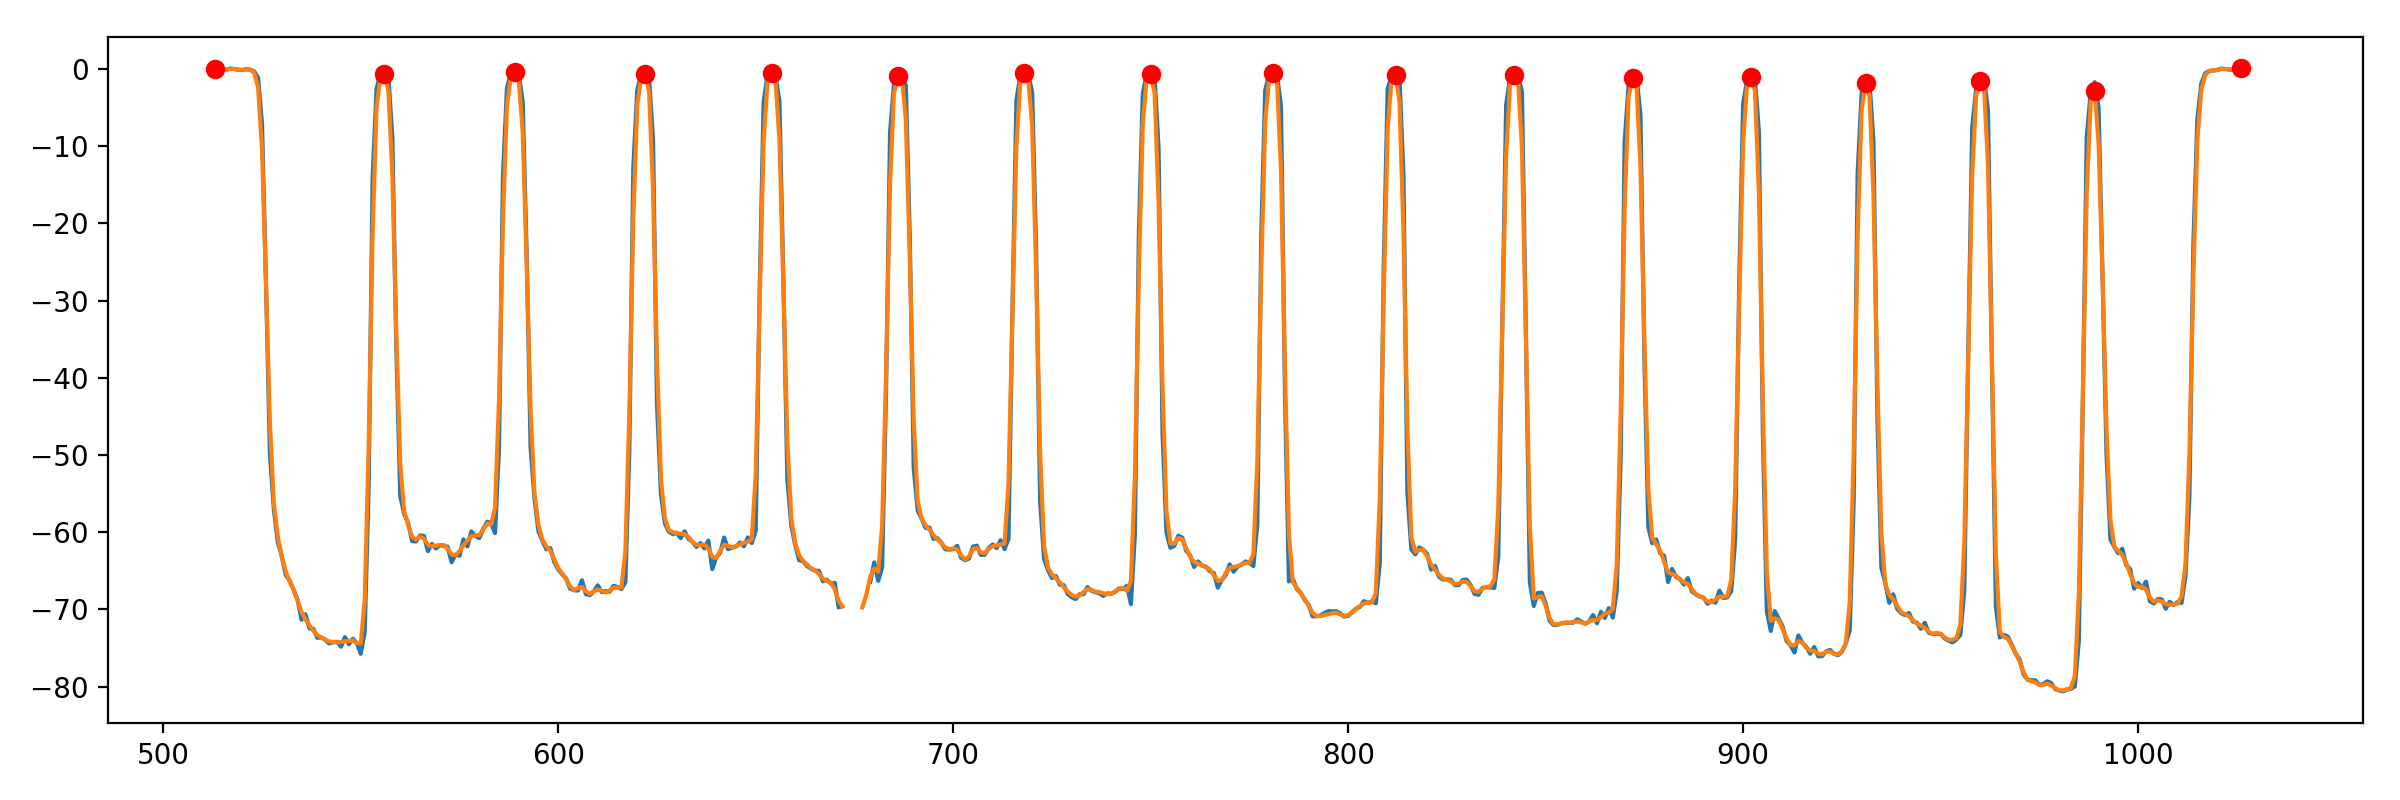

In [216]:
# Test single row - channel 3
band = '3A'
row  = 632

test_img = np.zeros(len(sci_signal[band][row,512:]))
peaks = funcs.find_peaks(-convolve(sci_signal[band],Box2DKernel(2))[row,512:], thres=0., min_dist=25)
if (512+peaks[0]>530):
    peaks = np.insert(peaks,0,0)
if (len(peaks) != len(sliceid3)+1) :
    peaks = funcs.find_peaks(-convolve(sci_signal[band],Box2DKernel(2))[row,512:]-np.min(-convolve(sci_signal[band],Box2DKernel(2))[row,512:][~np.isnan(-convolve(sci_signal[band],Box2DKernel(2))[row,512:])]), thres=0., min_dist=25)

plt.figure(figsize=(12,4))
plt.plot(512+np.arange(len(sci_signal[band][row,512:])),-sci_signal[band][row,512:])
plt.plot(512+np.arange(len(sci_signal[band][row,512:])),-convolve(sci_signal[band],Box2DKernel(2))[row,512:])
plt.plot(512+peaks,-convolve(sci_signal[band],Box2DKernel(2))[row,512:][peaks],'ro')
plt.tight_layout()

In [255]:
# Derive slice map - channel 4 band 4A and 4B
band = '4A' # '4A','4B'

sliceMap_0percent[band] = np.zeros((1024,1032))
for row in range(1,1023):
    if row%100 == 0:
        print 'Row {}'.format(row)
    peaks = funcs.find_peaks(-convolve(sci_signal[band],Box2DKernel(3))[row,:480], thres=0., min_dist=30)
    for i in range(len(peaks)-1):
        sliceMap_0percent[band][row,peaks[i]:peaks[i+1]] = sliceid4[i]
sliceMap_0percent[band][0,:]  = sliceMap_0percent[band][1,:].copy()
sliceMap_0percent[band][-1,:] = sliceMap_0percent[band][-2,:].copy()

Row 100
Row 200
Row 300
Row 400
Row 500
Row 600
Row 700
Row 800
Row 900
Row 1000


In [ ]:
# Test single row - channel 4 band 4A and 4B
band = '4A'
row  = 32

peaks = funcs.find_peaks(-convolve(sci_signal[band],Box2DKernel(3))[row,:480], thres=0., min_dist=30)

plt.figure(figsize=(12,4))
plt.plot(-sci_signal[band][row,:480])
plt.plot(-convolve(sci_signal[band],Box2DKernel(2))[row,:480])
plt.plot(peaks,-convolve(sci_signal[band],Box2DKernel(2))[row,:480][peaks],'ro')
plt.tight_layout()

# plt.figure()
# plt.plot(np.diff(peaks))
# plt.tight_layout()

In [270]:
# Derive slice map - channel 4 band 4C
band = '4C'

sliceMap_0percent[band] = np.zeros((1024,1032))
test_img = sci_signal[band].copy()
test_img[test_img<0] = 0.
for row in range(1,1023):
    if row%100 == 0:
        print 'Row {}'.format(row)
    peaks = funcs.find_peaks(-convolve(test_img,Box2DKernel(3))[row,:480], thres=0., min_dist=30)
    if (len(peaks) != len(sliceid4)+1) :
        peaks = funcs.find_peaks(-convolve(sci_signal[band],Box2DKernel(3))[row,:480]-np.min(-convolve(sci_signal[band],Box2DKernel(3))[row,:480][~np.isnan(-convolve(sci_signal[band],Box2DKernel(3))[row,:480])]), thres=0., min_dist=30)
    for i in range(len(peaks)-1):
        sliceMap_0percent[band][row,peaks[i]:peaks[i+1]] = sliceid4[i]
sliceMap_0percent[band][0,:]  = sliceMap_0percent[band][1,:].copy()
sliceMap_0percent[band][-1,:] = sliceMap_0percent[band][-2,:].copy()

/Users/ioannisa/anaconda2/envs/miricle.20170307/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in less


Row 100
Row 200
Row 300
Row 400
Row 500
Row 600
Row 700
Row 800
Row 900
Row 1000


/Users/ioannisa/anaconda2/envs/miricle.20170307/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in less


<IPython.core.display.Javascript object>


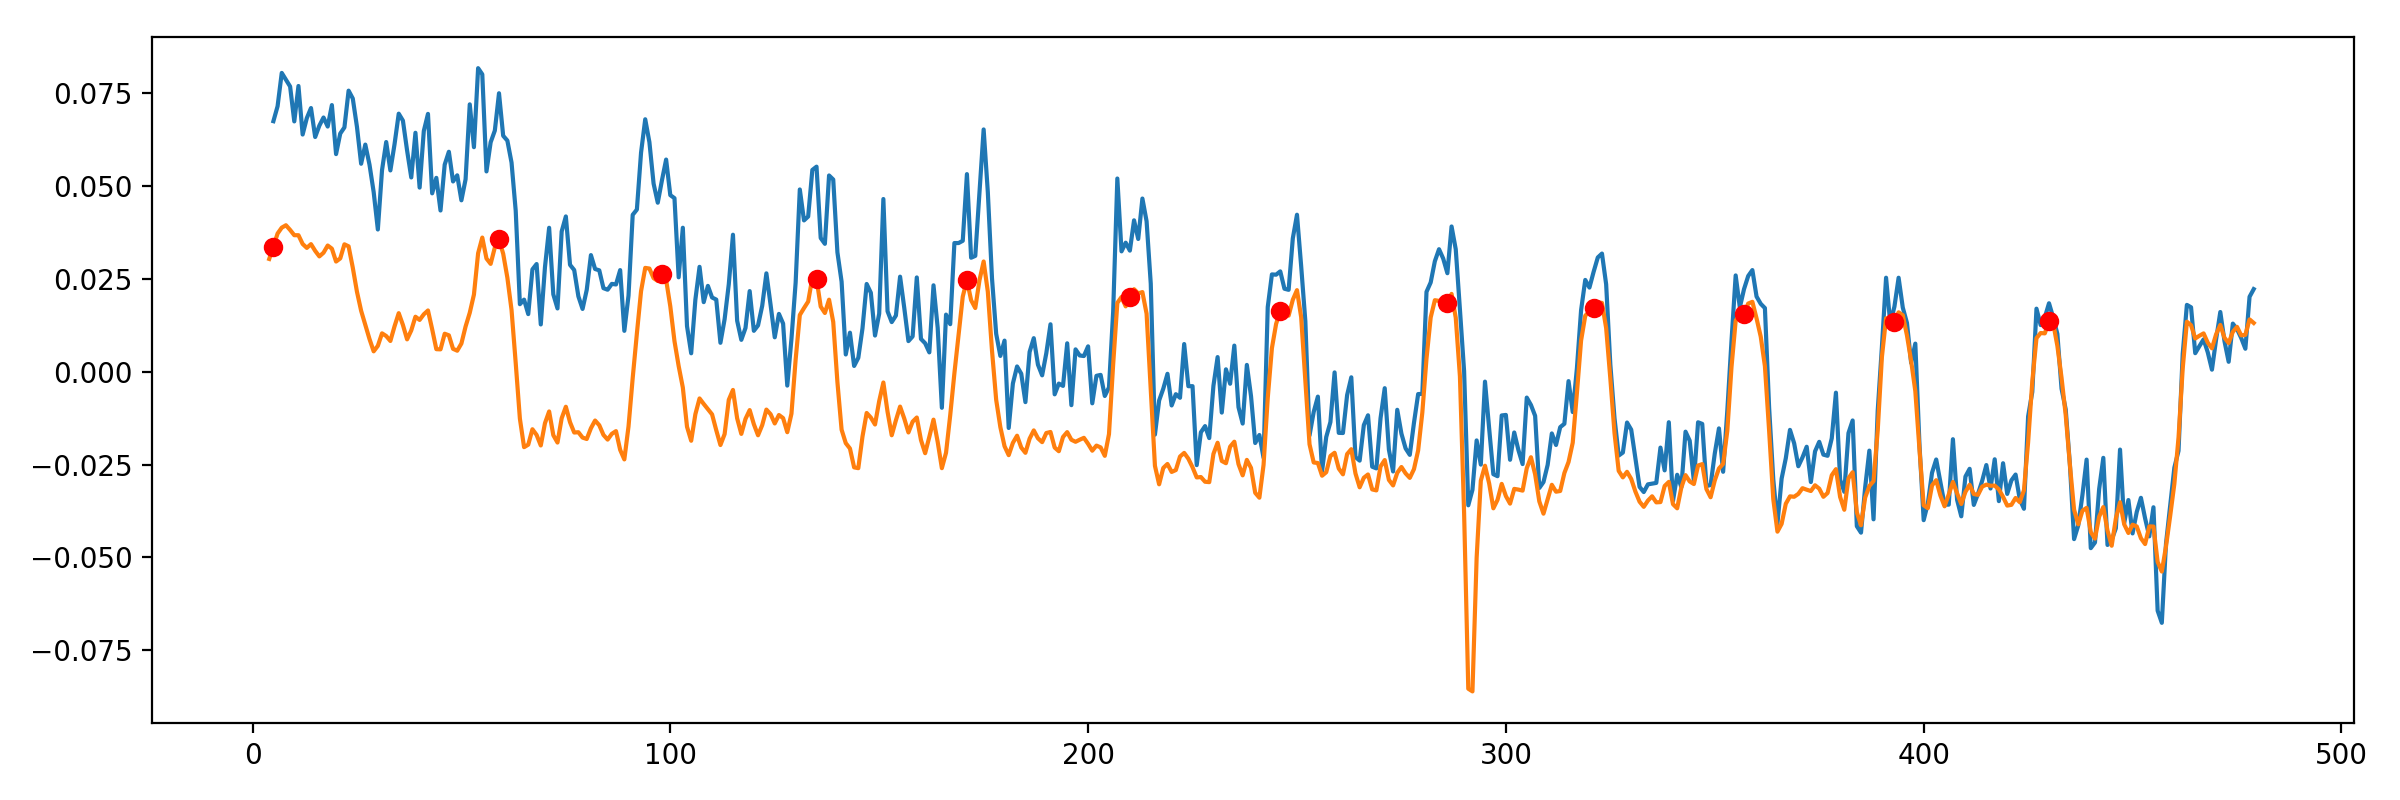

In [269]:
# Test single row - channel 4 band 4C -- Use 400K BB data!
band = '4C'
row  = 155

test_img = sci_signal[band].copy()
test_img[test_img<0] = 0.
peaks = funcs.find_peaks(-convolve(test_img,Box2DKernel(3))[row,:480], thres=0., min_dist=30)
if len(peaks) != len(sliceid4)+1:
    peaks = funcs.find_peaks(-convolve(test_img,Box2DKernel(3))[row,:480]-np.min(-convolve(test_img,Box2DKernel(3))[row,:480][~np.isnan(-convolve(test_img,Box2DKernel(3))[row,:480])]), thres=0., min_dist=30)

plt.figure(figsize=(12,4))
plt.plot(-sci_signal[band][row,:480])
plt.plot(-convolve(sci_signal[band],Box2DKernel(2))[row,:480])
plt.plot(peaks,-convolve(sci_signal[band],Box2DKernel(2))[row,:480][peaks],'ro')
plt.tight_layout()

# plt.figure()
# plt.plot(np.diff(peaks))
# plt.tight_layout()

<IPython.core.display.Javascript object>


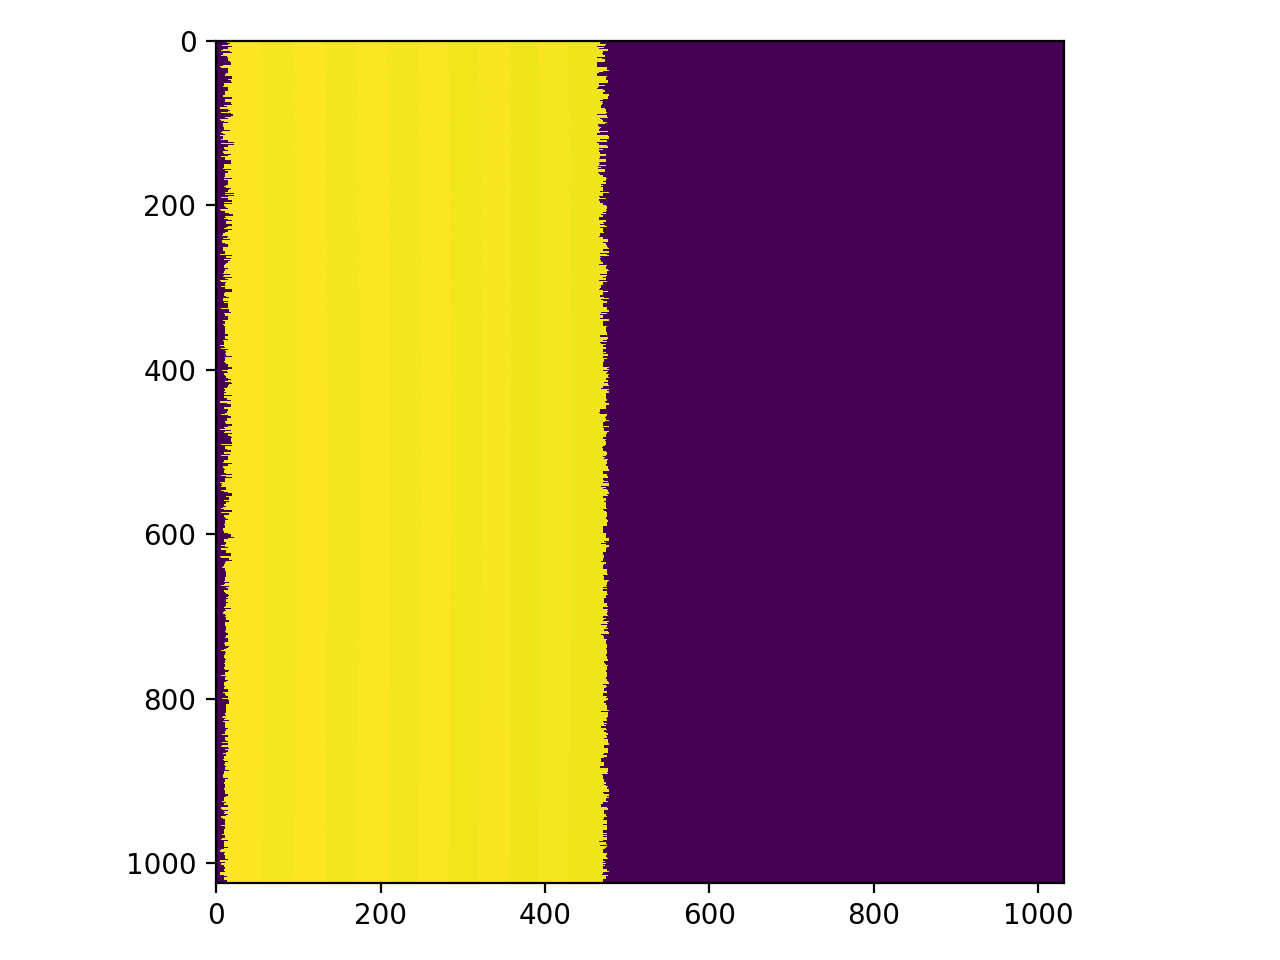

In [13]:
# plot result
band = '4C'
plt.figure()
plt.imshow(sliceMap_0percent[band])
plt.tight_layout()

In [272]:
# save outputs
funcs.save_obj(sliceMap_0percent,'sliceMap_0percent')